In [ ]:
!pip install tensorflow tensorflow-datasets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load 'TensoFlow Flowers' Dataset

dataset, info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split='train'
)

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.2529CN_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.ten

In [3]:
class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print("Classes:", class_names)
print("Total images:", info.splits['train'].num_examples)

Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Total images: 3670


In [4]:
# Split Data (Train/Validation)

TOTAL_IMAGES = info.splits['train'].num_examples
TRAIN_SIZE = int(0.8 * TOTAL_IMAGES)

dataset = dataset.shuffle(      # Shuffle BEFORE splitting
    buffer_size=TOTAL_IMAGES,
    seed=42,
    reshuffle_each_iteration=False
)

train_ds = dataset.take(TRAIN_SIZE)
val_ds = dataset.skip(TRAIN_SIZE)

print("Train size:", TRAIN_SIZE)
print("Validation size:", TOTAL_IMAGES - TRAIN_SIZE)

Train size: 2936
Validation size: 734


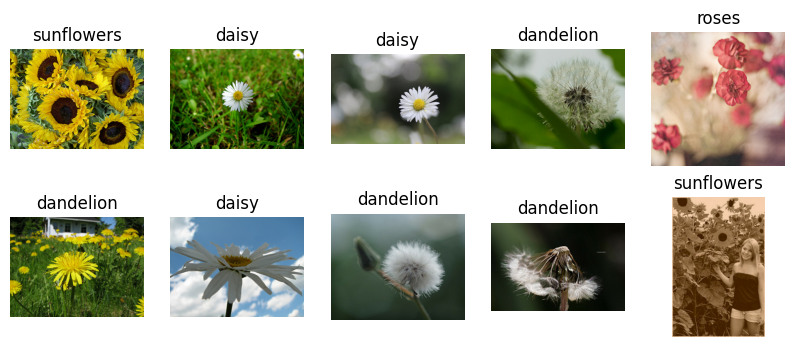

In [5]:
plt.figure(figsize=(10, 4))
for i, (image, label) in enumerate(train_ds.take(10)):
  ax = plt.subplot(2, 5, i+1)
  plt.imshow(image.numpy().astype('uint8'))
  plt.title(class_names[label.numpy()])
  plt.axis('off')

In [6]:
# Image Preprocessing

IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [7]:
train_ds = (
    train_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
# Load Pre Trained Mode

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Build Trasfer Learning Model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
# Compile Model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Train Model

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - accuracy: 0.4804 - loss: 1.2858 - val_accuracy: 0.7888 - val_loss: 0.6307
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8393 - loss: 0.5324 - val_accuracy: 0.8529 - val_loss: 0.4537
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8903 - loss: 0.3669 - val_accuracy: 0.8733 - val_loss: 0.3713
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9114 - loss: 0.3010 - val_accuracy: 0.8815 - val_loss: 0.3427
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9291 - loss: 0.2533 - val_accuracy: 0.8883 - val_loss: 0.3305
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9380 - loss: 0.2220 - val_accuracy: 0.8965 - val_loss: 0.3084
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9458 - loss: 0.1967 - val_accuracy: 0.9074 - val_loss: 0.3020
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9513 - loss: 0.1792 - val_accuracy: 0.9005 -

In [ ]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

In [12]:
#Convert Model to TensorFlow Lite

model.export("tf_flowers_model")

converter = tf.lite.TFLiteConverter.from_saved_model("tf_flowers_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("/content/drive/MyDrive/Machine Learning/Image Based/Flower_Classification/Flower_Classification_1/flowers_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully.")

Saved artifact at 'tf_flowers_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140601824406288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824406480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824408592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824408400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824406864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824408784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824408208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824409936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824407824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140601824408976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1406018244

In [13]:
# Save Labels File

with open("/content/drive/MyDrive/Machine Learning/Image Based/Flower_Classification/Flower_Classification_1/labels.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("labels.txt saved.")

labels.txt saved.
